In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%pip install adversarial-robustness-toolbox  # HOW TO INSTALL

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# The Adversarial Robustness Toolbox from IBM Research



## Introduction

Adversarial Robustness Toolbox (ART) is a Python library for Machine Learning Security. It provides tools that enable developers and researchers to defend and evaluate Machine Learning models and applications against the adversarial threats of **Evasion, Poisoning, Extraction, and Inference**.

![white_hat_blue_red](https://drive.google.com/uc?export=view&id=1dCxNWDy5jGad1UKxZRCMpLgMF-QUibhH)

ART supports all popular machine learning frameworks (TensorFlow, Keras, PyTorch, MXNet, scikit-learn, XGBoost, LightGBM, CatBoost, GPy, etc.), all data types (images, tables, audio, video, etc.) and machine learning tasks (classification, object detection, speech recognition, generation, certification, etc.).

It is available at: https://github.com/Trusted-AI/adversarial-robustness-toolbox

---

Here are some useful references:

https://www.youtube.com/watch?v=tTN_BqTv440

https://www.youtube.com/watch?v=TygPgJYKRUI

https://www.youtube.com/watch?v=BDxTVOimUec

---


# More on Attacks

## Import necessary libraries

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent # Can directly import the attack. Explore this function
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist  # The library also contains the common datasets like MNIST and CIFAR10

## Step 0: Define the neural network model, return logits instead of activation in forward method

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

## Step 1: Load MNIST Data

MNIST is an image dataset of handwritten digits (28 pixels by 28 pixels) in grayscale. This is often thought to be the "hello, world!" of image classification/computer vision problems -- much like the Iris flower dataset is for non-NN-based machine learning.

In [ ]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

In [ ]:
print("The shape of x_train is: ", np.shape(x_train))
print("The shape of y_train is: ", np.shape(y_train))
print("The shape of x_test is: ", np.shape(x_test))
print("The shape of y_test is: ", np.shape(y_test))

The shape of x_train is:  (60000, 28, 28, 1)
The shape of y_train is:  (60000, 10)
The shape of x_test is:  (10000, 28, 28, 1)
The shape of y_test is:  (10000, 10)


## Step 1a: Visualise the data (Benign Training Data)

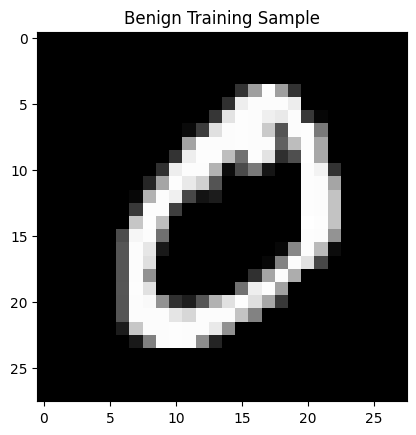

In [ ]:
plt.imshow(x_train[1,...].squeeze(), cmap='gray')  # This is the second sample
plt.title("Benign Training Sample")
plt.show()

## Step 1b: Swap axes to Pytorch's B x CHW format

In [ ]:
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

print("The shape of x_train is: ", np.shape(x_train))  # Black or white == 1 channel
print("The shape of y_train is: ", np.shape(y_train))
print("The shape of x_test is: ", np.shape(x_test))
print("The shape of y_test is: ", np.shape(y_test))

The shape of x_train is:  (60000, 1, 28, 28)
The shape of y_train is:  (60000, 10)
The shape of x_test is:  (10000, 1, 28, 28)
The shape of y_test is:  (10000, 10)


## Step 2: Create the model

In [ ]:
model = Net()

## Step 2a: Define the loss function and the classifier

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Step 3: Create the classifier to use with ART

In [ ]:
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),  # Note the input shape
    nb_classes=10,  # Number of classes is defined as 10
)

## Step 4: Train the classifier

In [ ]:
num_epochs = 3
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=num_epochs)

## Step 5: Evaluate the ART classifier on benign (untampered) test examples

In [ ]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {:3}%".format(accuracy * 100))

Accuracy on benign test examples: 97.57000000000001%


## Step 6: Generate adversarial test examples

In [ ]:
epsilon = 0.2
attack = FastGradientMethod(estimator=classifier, eps=epsilon)
x_test_adv = attack.generate(x=x_test)

## Step 6a: Compare the benign with the adversarial sample

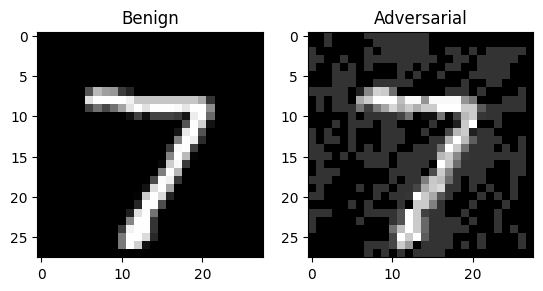

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_test[0,...].squeeze(), cmap='gray')
axarr[0].set_title('Benign')
axarr[1].imshow(x_test_adv[0,...].squeeze(), cmap='gray')
axarr[1].set_title('Adversarial')
plt.show()

## Step 7: Evaluate the ART classifier on adversarial test examples

In [ ]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on normal test examples: {:3}%".format(accuracy * 100))

print("-----")

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {:3}%".format(accuracy * 100))

Accuracy on normal test examples: 96.89999999999999%
-----
Accuracy on adversarial test examples: 13.270000000000001%


# One Method of Defence - Adversarial Training/Data Augmentation

## Let's now try to create more adversarial examples but this time for training

In [ ]:
adv_crafter = FastGradientMethod(estimator=classifier, eps=0.2)
x_train_adv = adv_crafter.generate(x_train)

print("The shape of x_train_adv is: ", np.shape(x_train_adv))

The shape of x_train_adv is:  (60000, 1, 28, 28)


## Data augmentation step

In [ ]:
# Expand the training set with the adversarial samples
x_train = np.append(x_train, x_train_adv, axis=0)
y_train = np.append(y_train, y_train, axis=0)  # Repeats the labels

In [ ]:
print("The shape of x_train is: ", np.shape(x_train))
print("The shape of y_train is: ", np.shape(y_train))
print("The shape of x_test is: ", np.shape(x_test))
print("The shape of y_test is: ", np.shape(y_test))

The shape of x_train is:  (180000, 1, 28, 28)
The shape of y_train is:  (240000, 10)
The shape of x_test is:  (10000, 1, 28, 28)
The shape of y_test is:  (10000, 10)


## Let's not just double our training dataset size. Sample from it

In [ ]:
# Shuffle the arrays
shuffle_indices = np.random.permutation(len(x_train))  # Generate random permutation
x_train_shuffled = x_train[shuffle_indices]
y_train_shuffled = y_train[shuffle_indices]

# Take the first n samples  (keep the size of x_train the same)
n = len(x_train)//2
x_train_new = x_train_shuffled[:n]
y_train_new = y_train_shuffled[:n]

## Let's create a new CNN-based classifier for "Robust" Training

In [ ]:
robust_classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),  # Note the input shape
    nb_classes=10,  # Number of classes is defined as 10
)

## Train the classifier on the new dataset OR just re-train the old one

In [ ]:
num_epochs = 3
robust_classifier.fit(x_train_new, y_train_new, batch_size=64, nb_epochs=num_epochs)

## Re-evaluate the adversarially trained classifier on the test set

In [ ]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on normal test examples: {:3}%".format(accuracy * 100))

print("-----")

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {:3}%".format(accuracy * 100))

Accuracy on normal test examples: 97.38%
-----
Accuracy on adversarial test examples: 96.25%


Summary of learning:

We first evaluated a standard MNIST classifier on adversarially perturbed test examples without any robustness training. While the model achieved 96.9% accuracy on clean test data, its performance dropped sharply to 13.27% accuracy on adversarial examples. This result shows that high test accuracy alone does not imply robustness, as even small and imperceptible perturbations can reliably fool a normally trained classifier.

We then trained the same model using adversarial training, where adversarial examples were included during the training process. After adversarial training, the model achieved 97.38% accuracy on clean test data and 96.25% accuracy on adversarial test examples. This demonstrates that the model learned to correctly classify inputs even when adversarial perturbations were present.

Comparing the two settings leads to three key insights. First, adversarial vulnerability is a fundamental weakness of standard training rather than a rare edge case. Second, adversarial training can dramatically improve robustness, increasing adversarial accuracy from around 13% to over 96%, while preserving clean data performance. Third, robustness must be explicitly optimized, as it does not emerge automatically from standard empirical risk minimization.

Overall, this experiment shows that adversarial training reshapes the model’s decision boundaries to be more stable under input perturbations, while maintaining strong generalization on clean data.



## **... Next steps:**

Some other resources:
- https://github.com/fra31/auto-attack
- https://robustbench.github.io/
- https://github.com/bethgelab/foolbox
- https://github.com/cleverhans-lab/cleverhans

Some noteworthy researchers whose work you could look into:
- Ian Goodfellow - https://scholar.google.ca/citations?hl=en&user=iYN86KEAAAAJ&view_op=list_works&sortby=pubdate
- Florian Tramèr - https://scholar.google.ch/citations?hl=en&user=ijH0-a8AAAAJ&view_op=list_works&sortby=pubdate
- Nicholas Carlini - https://scholar.google.com/citations?hl=en&user=q4qDvAoAAAAJ&view_op=list_works&sortby=pubdate
- Nicolas Papernot - https://scholar.google.com/citations?hl=en&user=cGxq0cMAAAAJ&view_op=list_works&sortby=pubdate
- Lorenzo Cavallaro (UCL) - https://scholar.google.com/citations?hl=en&user=oWT7fIYAAAAJ&view_op=list_works&sortby=pubdate


